In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import timeit
import seaborn as sns
import scipy.stats as stats

### Cumulative Advantage

For each (filtered) cohort analyze how the distribution of publications changes in the cohort over time.
At the beginning all scientists should be equal (they have zero publications). Over time some scientists become more successful than others which leads to an increase in the Gini coefficient.

In [2]:
start_time = timeit.default_timer()
print(start_time)

1510327274.17


In [3]:
gender = pd.read_csv('./data/name_gender_1970_2016_noAsians.csv')
gender.rename(columns={'name':'author'},inplace=True)
print(gender.head())
print(gender['gender'].unique())
print(gender['author'].nunique())

# some names occur multiple times, but the gender assignment should be the same.
#counts = gender.groupby('author').size()
#df2 = pd.DataFrame(counts, columns = ['size'])
#print(df2.head())
#print(df2[df2['size'] > 1])

             author gender
0    nima mesgarani      m
1    james j. abbas      m
2  eberhart zrenner      m
3    emery n. brown      m
4        ilya rybak      m
['m' 'none' 'f']
1129473


In [5]:
max_years = 15
authorStartEndCareerData = pd.read_csv('data/authors-scientific-start-end-year-publish-count.csv')
credibleAuthorStartEndCareerData = pd.read_csv('./data/authors-scientific-atleast-15-year.csv')
#authorStartEndCareerData = pd.read_csv('data/authors-scientific-atleast-20-year-20-papers.csv')
print(authorStartEndCareerData.head())
print("authorStartEndCareerData  %s", authorStartEndCareerData.shape[0])
print("author unique names  %s", authorStartEndCareerData['author'].nunique())
print(authorStartEndCareerData[authorStartEndCareerData['author']=='a min tjoa'])
print(authorStartEndCareerData.describe())

                  author  start_year  end_year  pub_count
0       'maseka lesaoana        2001      2015          2
1  (max) zong-ming cheng        2009      2011          2
2       (zhou) bryan bai        2011      2012          2
3                  a lun        2010      2010          1
4             a min tjoa        1979      2015        193
('authorStartEndCareerData  %s', 1708185)
('author unique names  %s', 1708185)
       author  start_year  end_year  pub_count
4  a min tjoa        1979      2015        193
           start_year        end_year       pub_count
count  1708185.000000  1708185.000000  1708185.000000
mean      2005.758260     2009.158546        5.314553
std          8.420414        7.425803       15.903616
min       1970.000000     1970.000000        1.000000
25%       2002.000000     2007.000000        1.000000
50%       2008.000000     2012.000000        1.000000
75%       2012.000000     2014.000000        4.000000
max       2016.000000     2016.000000     1206.

In [33]:
authorStartEndCareerData = pd.merge(authorStartEndCareerData, gender, how="left", on=["author"])
print(authorStartEndCareerData.head())
credibleAuthorStartEndCareerData = pd.merge(credibleAuthorStartEndCareerData, gender, how="left", on=["author"])

                  author  start_year  end_year  pub_count gender
0       'maseka lesaoana        2001      2015          2   none
1       'maseka lesaoana        2001      2015          2   none
2  (max) zong-ming cheng        2009      2011          2    NaN
3       (zhou) bryan bai        2011      2012          2    NaN
4                  a lun        2010      2010          1    NaN


In [34]:
authorStartEndCareerData['gender'] = authorStartEndCareerData['gender'].fillna('none')
credibleAuthorStartEndCareerData['gender'] = credibleAuthorStartEndCareerData['gender'].fillna('none')
print(authorStartEndCareerData.head())
#print(authorStartEndCareerData.describe())

                  author  start_year  end_year  pub_count gender
0       'maseka lesaoana        2001      2015          2   none
1       'maseka lesaoana        2001      2015          2   none
2  (max) zong-ming cheng        2009      2011          2   none
3       (zhou) bryan bai        2011      2012          2   none
4                  a lun        2010      2010          1   none


('authorStartEndCareerData with duplicates: %s', 6372557)
('authorStartEndCareerData no duplicates: %s', 1708185)
1708185
('credible authorStartEndCareerData with duplicates: %s', 2368899)
('credible authorStartEndCareerData no duplicates: %s', 110888)
110888
1708185


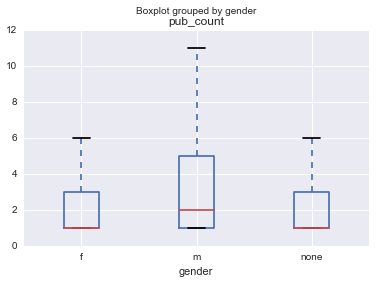

In [35]:

# there are no duplicates
print("authorStartEndCareerData with duplicates: %s", authorStartEndCareerData.shape[0])

authorStartEndCareerData = authorStartEndCareerData.drop_duplicates()
print("authorStartEndCareerData no duplicates: %s", authorStartEndCareerData.shape[0])
print(authorStartEndCareerData['author'].nunique())

# there are no duplicates
print("credible authorStartEndCareerData with duplicates: %s", credibleAuthorStartEndCareerData.shape[0])

credibleAuthorStartEndCareerData = credibleAuthorStartEndCareerData.drop_duplicates()
print("credible authorStartEndCareerData no duplicates: %s", credibleAuthorStartEndCareerData.shape[0])
print(credibleAuthorStartEndCareerData['author'].nunique())

test = authorStartEndCareerData[["pub_count", "gender"]]
print(test.shape[0])

#print(test.head())
#print(authorStartEndCareerData[["start_year", "gender", "pub_count"]].groupby(['start_year', 'gender']).agg({'count', 'mean', 'std'}))
authorStartEndCareerData.boxplot(column='pub_count', by='gender', showfliers=False)

In [6]:
authorPublicationsData = pd.read_csv('data/author_publications_1970_2016_asiansAsNone.txt')
authorPublicationsData = authorPublicationsData[authorPublicationsData["year"] > 1900]

In [7]:
authorPublicationsData[authorPublicationsData['author'] == 'allan h. levy']

,author,year,pub_id
5078072,allan h. levy,1977,53e9a6a6b7602d9702fd9913


In [18]:

selectedAuthor = authorStartEndCareerData["author"].unique()
print(len(selectedAuthor))

authorPublicationsData = pd.read_csv('data/author_publications_1970_2016_asiansAsNone.txt')
authorPublicationsData = authorPublicationsData[authorPublicationsData["year"] > 1900]
print(authorPublicationsData.head(n=1))

print("authorPublicationsData")
print(authorPublicationsData['author'].nunique())
#print(authorPublicationsData.index)
print(authorPublicationsData.shape[0])



# contains only authors-scientific-atleast-15-year --> we filter authorPublicationsData that only those authors are inlcuded

print("authorStartEndCareerData")
print(authorStartEndCareerData['author'].nunique())
#print(authorStartEndCareerData.index)
print(authorStartEndCareerData.shape[0])

#authorPublicationsData = pd.merge(authorPublicationsData, authorStartEndCareerData,  how="left", left_on="author", right_on="author")


#authorPublicationsData = authorPublicationsData.dropna(how='any')
#print(authorPublicationsData.head(n=2))
#print(authorPublicationsData['author'].nunique())
#print(authorPublicationsData.shape[0])


#get the year list - as it helps to enumerate and find gini co-efficient for each year (irrespective of the dataset)
#years = np.sort(authorPublicationsData['year'].unique())
#print(years)

1708185
             author  year                    pub_id
0  kim l. blackwell  2014  55503da645ce0a409eb273e8
authorPublicationsData
1708185
9078240
authorStartEndCareerData
1708185
1708185


In [19]:
print(authorPublicationsData.head(n=3))

             author  year                    pub_id
0  kim l. blackwell  2014  55503da645ce0a409eb273e8
1    nima mesgarani  2014  55503da645ce0a409eb273e9
2    james j. abbas  2014  55503da645ce0a409eb273ea


In [20]:


#groupByStartYearScientificCareerData = authorStartEndCareerData[['author','start_year']].groupby(['start_year'])
#print(groupByStartYearScientificCareerData.head())
#groupByStartYearScientificCareerData.groups

In [21]:
#Group by both year and author - multi index and hierarchial indexing
#authorPublicationsData

print(authorPublicationsData[authorPublicationsData.author=="a min tjoa"].head(n=5))

groupByAuthorYearData = authorPublicationsData.groupby(['year','author']).count().reset_index()
groupByAuthorYearData.rename(columns={'pub_id':'num_pub'}, inplace=True)

#remove wrong data
groupByAuthorYearData = groupByAuthorYearData[groupByAuthorYearData["year"] > 1900]
print(groupByAuthorYearData.head())

print(groupByAuthorYearData[groupByAuthorYearData.author=="a min tjoa"].head(n=5))


           author  year                    pub_id
47504  a min tjoa  2004  53e9ac96b7602d9703671ea0
81537  a min tjoa  2008  53e9b403b7602d9703ef2cf3
81583  a min tjoa  2007  53e9aad9b7602d970345a7fb
81770  a min tjoa  2013  53e9b783b7602d9704329922
81790  a min tjoa  2003  53e9ae29b7602d970383a84d
   year         author  num_pub
0  1970    a. a. afifi        1
1  1970    a. a. bährs        1
2  1970     a. armenti        1
3  1970  a. b. slomson        1
4  1970    a. brindley        1
        year      author  num_pub
33624   1979  a min tjoa        1
85854   1985  a min tjoa        1
98140   1986  a min tjoa        1
175702  1990  a min tjoa        1
203981  1991  a min tjoa        3


In [22]:

#remove wrong data
groupByAuthorYearData = groupByAuthorYearData[groupByAuthorYearData["year"] > 1900]
print(groupByAuthorYearData.head())


print(groupByAuthorYearData[groupByAuthorYearData.author=="a min tjoa"])

# cumulative number of publications per author
groupByAuthorYearData = groupByAuthorYearData.set_index('year').sort_index()
#print(groupByAuthorYearData.head())

groupByAuthorYearData["cum_num_pub"] = groupByAuthorYearData.groupby(['author'])['num_pub'].transform(pd.Series.cumsum)
groupByAuthorYearData = groupByAuthorYearData.reset_index()
print(groupByAuthorYearData.head())




groupByAuthorYearData = pd.merge(groupByAuthorYearData, authorStartEndCareerData,  how="left", left_on="author", right_on="author")

groupByAuthorYearData = groupByAuthorYearData.dropna(how='any')
print(groupByAuthorYearData.head(n=2))
print(groupByAuthorYearData['author'].nunique())
print(groupByAuthorYearData.shape[0])

print(groupByAuthorYearData.head())
print(groupByAuthorYearData[groupByAuthorYearData.author=="a min tjoa"])


groupByAuthorYearData = groupByAuthorYearData.reset_index()
print(groupByAuthorYearData.head())


   year         author  num_pub
0  1970    a. a. afifi        1
1  1970    a. a. bährs        1
2  1970     a. armenti        1
3  1970  a. b. slomson        1
4  1970    a. brindley        1
         year      author  num_pub
33624    1979  a min tjoa        1
85854    1985  a min tjoa        1
98140    1986  a min tjoa        1
175702   1990  a min tjoa        1
203981   1991  a min tjoa        3
236094   1992  a min tjoa        3
273388   1993  a min tjoa        6
318615   1994  a min tjoa        2
369987   1995  a min tjoa        3
424963   1996  a min tjoa        5
483601   1997  a min tjoa        2
550109   1998  a min tjoa        3
707406   2000  a min tjoa        8
801241   2001  a min tjoa        5
905248   2002  a min tjoa        3
1021243  2003  a min tjoa       11
1161071  2004  a min tjoa        8
1326572  2005  a min tjoa       13
1519278  2006  a min tjoa       23
1733581  2007  a min tjoa       13
1971162  2008  a min tjoa        8
2230416  2009  a min tjoa        8
251

In [23]:
#the following snippet is taken from the github project and the license is creative commons
#https://github.com/oliviaguest/gini

def gini(array):
    """Calculate the Gini coefficient of a numpy array."""
    # based on bottom eq:
    # http://www.statsdirect.com/help/generatedimages/equations/equation154.svg
    # from:
    # http://www.statsdirect.com/help/default.htm#nonparametric_methods/gini.htm
    # All values are treated equally, arrays must be 1d:
    array = array.flatten()
    if np.min(array) < 0:
        # Values cannot be negative:
        array -= np.min(array)
    # Values cannot be 0:
    array += 0.0000001
    # Values must be sorted:
    array = np.sort(array)
    # Index per array element:
    index = np.arange(1,array.shape[0]+1)
    # Number of array elements:
    n = array.shape[0]
    # Gini coefficient:
    return ((np.sum((2 * index - n  - 1) * array)) / (n * np.sum(array)))

### To check whether GINI calculation works correctly or not

In [24]:
#print(gini[1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
#print(gini(range(10)))

In [25]:
def plot_gender_numcumpub2(ax, cohort_duration, selected_cumnumpub_df, year):   
    #ax.errorbar(cohort_duration, selected_cumnumpub_df["mean_f"].values,  yerr=selected_cumnumpub_df["sem_f"].values, label='women', color="red" )
    #ax.errorbar(cohort_duration, selected_cumnumpub_df["mean_m"].values,  yerr=selected_cumnumpub_df["sem_m"].values, label='men', color="blue")
    #ax.errorbar(cohort_duration, selected_cumnumpub_df["mean_n"].values,  yerr=selected_cumnumpub_df["sem_n"].values, label='unknown', color="grey")
   
    ax.plot(cohort_duration, selected_cumnumpub_df["mean_f"].values,  label='women', color="red")
    ax.fill_between(cohort_duration, selected_cumnumpub_df["mean_f"].values-selected_cumnumpub_df["sem_f"].values, 
                     selected_cumnumpub_df["mean_f"].values+selected_cumnumpub_df["sem_f"].values,
    alpha=0.2, edgecolor='red', facecolor='red',
    linewidth=4, linestyle='dashdot', antialiased=True)
    
    #ax.set_title("Cohort start-year: "+str(year))
    
    return sep



# plot num cum publication stats
def plot_gender_numcumpub(ax, cohort_duration, selected_cumnumpub_df, year):
    ax.plot(cohort_duration, selected_cumnumpub_df["mean_f"].values,  label='women', color="red")
    ax.fill_between(cohort_duration, selected_cumnumpub_df["mean_f"].values-selected_cumnumpub_df["sem_f"].values, 
                     selected_cumnumpub_df["mean_f"].values+selected_cumnumpub_df["sem_f"].values,
    alpha=0.2, edgecolor='red', facecolor='red',
    linewidth=4, linestyle='dashdot', antialiased=True)
    
    ax.plot(cohort_duration, selected_cumnumpub_df["mean_m"].values,  label='men', color="blue")
    ax.fill_between(cohort_duration, selected_cumnumpub_df["mean_m"].values-selected_cumnumpub_df["sem_m"].values, 
                     selected_cumnumpub_df["mean_m"].values+selected_cumnumpub_df["sem_m"].values,
    alpha=0.2, edgecolor='blue', facecolor='blue',
    linewidth=4, linestyle='dashdot', antialiased=True)

    ax.plot(cohort_duration, selected_cumnumpub_df["mean_n"].values,  label='unknown', color="grey")
    ax.fill_between(cohort_duration, selected_cumnumpub_df["mean_n"].values-selected_cumnumpub_df["sem_n"].values, 
                     selected_cumnumpub_df["mean_n"].values+selected_cumnumpub_df["sem_n"].values,
    alpha=0.2, edgecolor='grey', facecolor='grey',
    linewidth=4, linestyle='dashdot', antialiased=True)
    
    #ax.errorbar(cohort_duration, selected_cumnumpub_df["mean_f"].values,  yerr=selected_cumnumpub_df["sem_f"].values, label='women', color="red" )
    #ax.errorbar(cohort_duration, selected_cumnumpub_df["mean_m"].values,  yerr=selected_cumnumpub_df["sem_m"].values, label='men', color="blue")
    #ax.errorbar(cohort_duration, selected_cumnumpub_df["mean_n"].values,  yerr=selected_cumnumpub_df["sem_n"].values, label='unknown', color="grey")
   
  
    return ax



    
  

   

    # Make one Bar Chart per COHORT
    #fig, ax = plt.subplots()
    #width = 0.3       # the width of the bars
    #Y = len(gini_years)
    #ind = np.arange(Y)
    #ax.set_title('Inequality for cohort: '+str(year))
    #rects = ax.bar(ind, gini_coefs, width, color='b')
    #ax.set_xticks(ind + width / 2)
    #ax.set_xticklabels(gini_years, rotation=90)
    #ax.set_ylabel('Gini')
    #plt.show()
    

### Num-publication distribution of each cohort in each year

* We compute the gini coefficient for each cohort in each year separately based on the cumulative number of publications that this group has aggregated. 
* We compute the mean and std of the cumulative number of publications for men and women in each cohort separately.


In [27]:

#get the year list - as it helps to enumerate and find gini co-efficient for each year (irrespective of the dataset)
years = np.sort(authorPublicationsData['year'].unique())
print(years)

[1970 1971 1972 1973 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984
 1985 1986 1987 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999
 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014
 2015 2016]


/usr/local/lib/python2.7/dist-packages/numpy-1.12.0.dev0_5b91628-py2.7-linux-x86_64.egg/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/usr/local/lib/python2.7/dist-packages/numpy-1.12.0.dev0_5b91628-py2.7-linux-x86_64.egg/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/usr/local/lib/python2.7/dist-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


             author  start_year  end_year  pub_count gender
0  'maseka lesaoana        2001      2015          2   none


/usr/local/lib/python2.7/dist-packages/matplotlib/pyplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


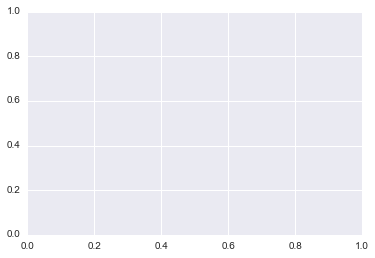

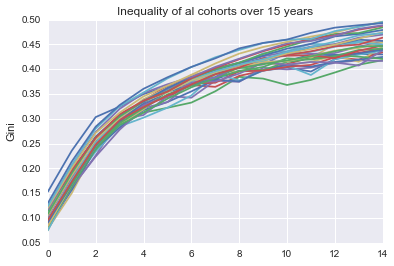

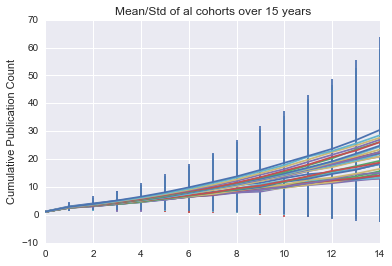

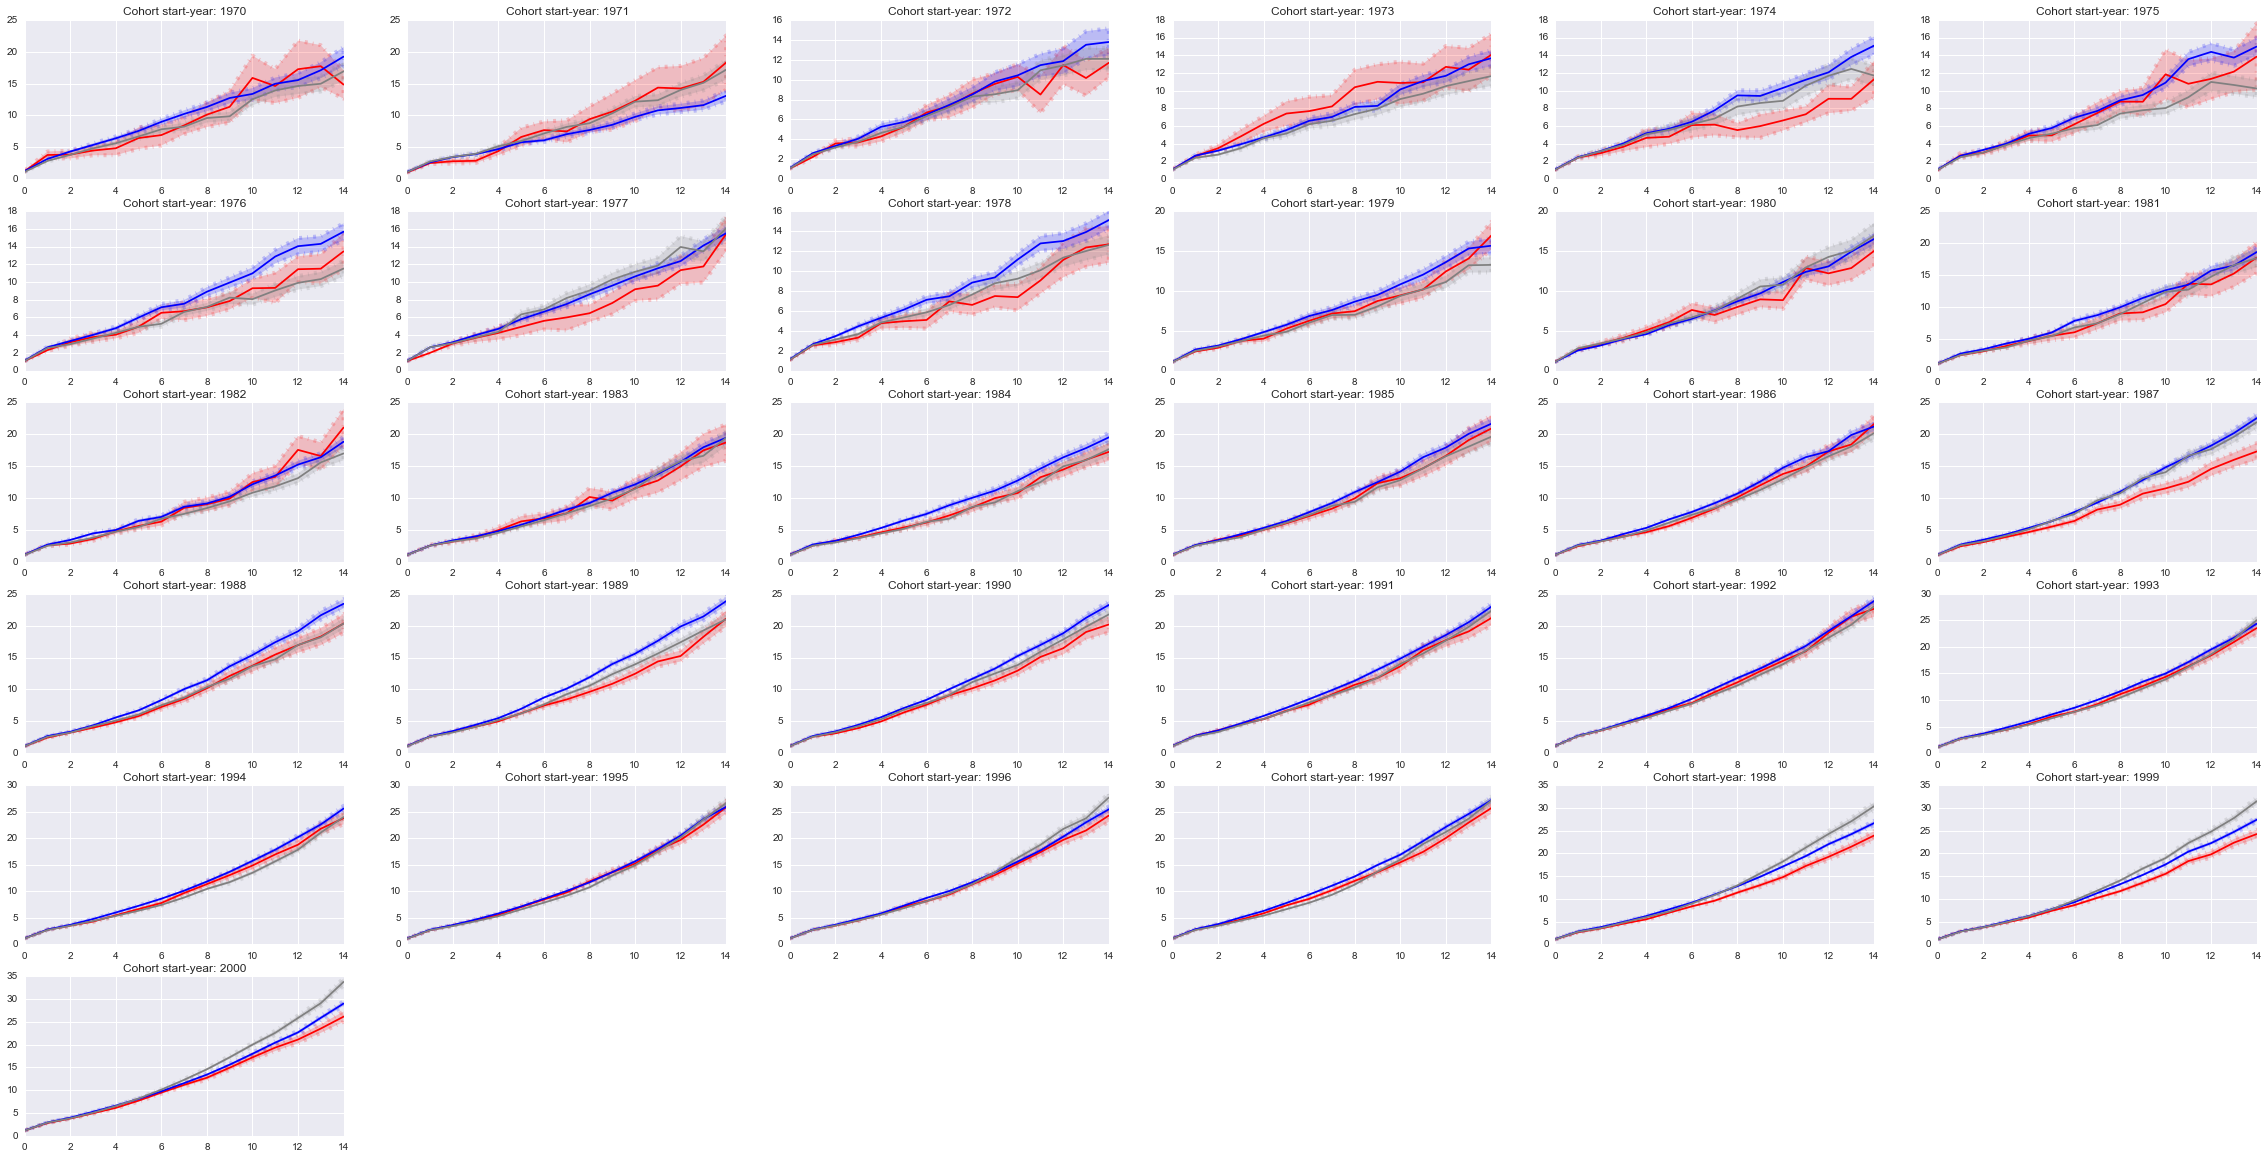

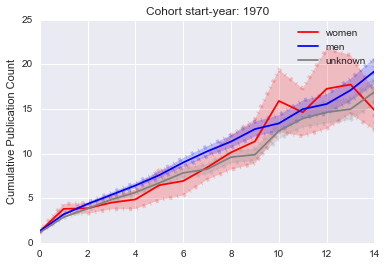

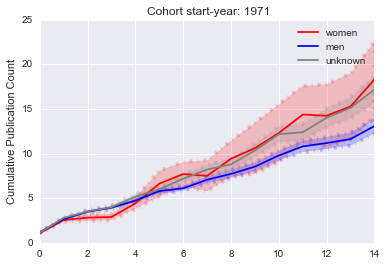

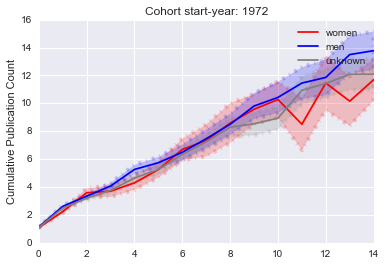

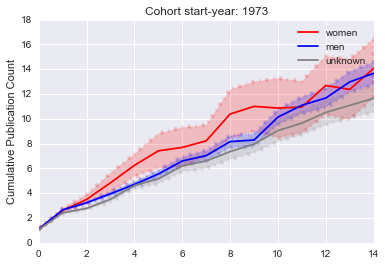

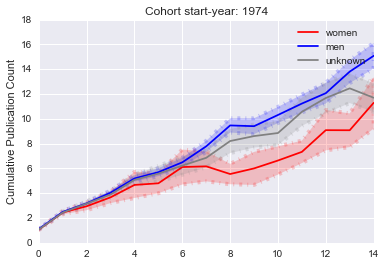

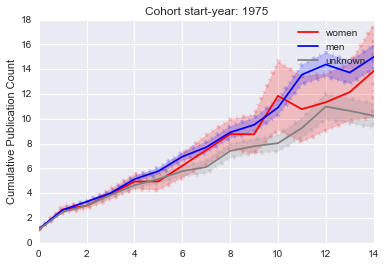

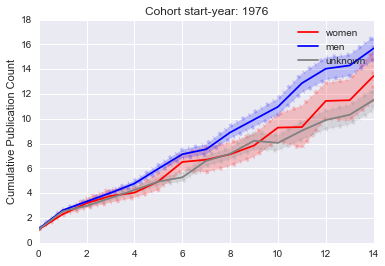

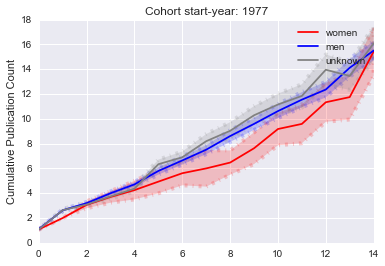

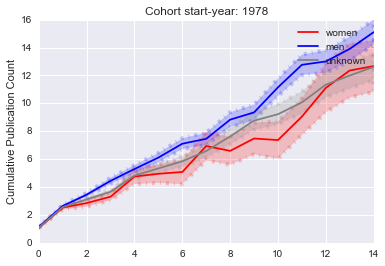

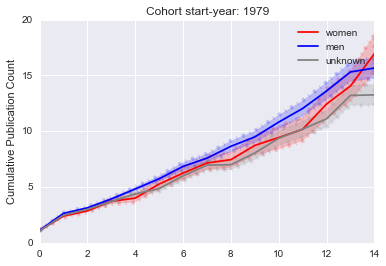

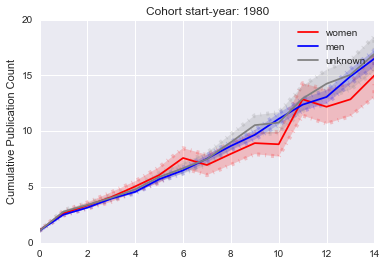

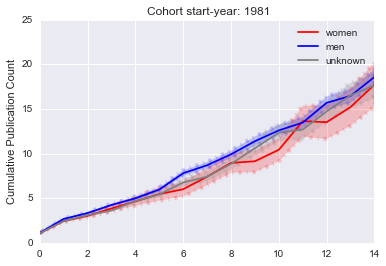

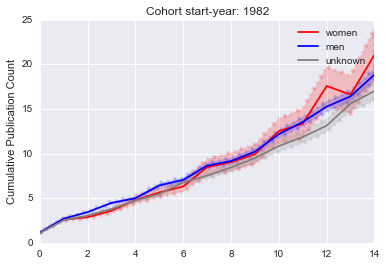

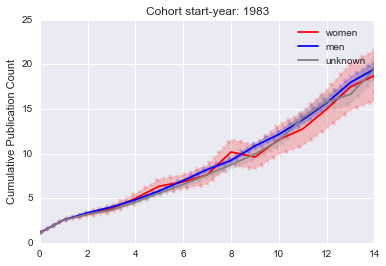

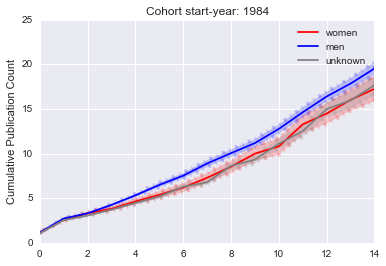

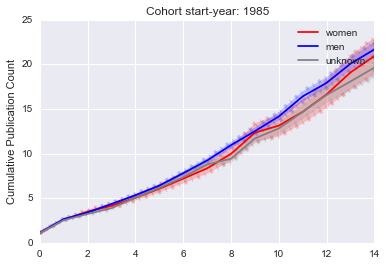

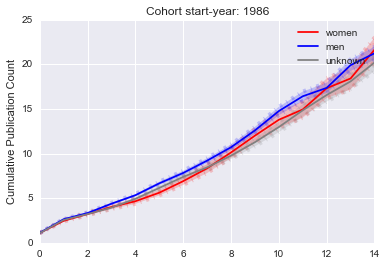

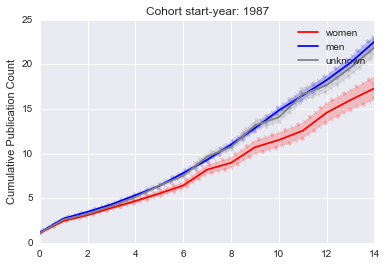

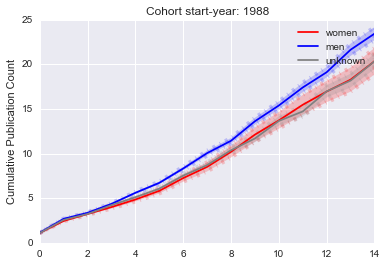

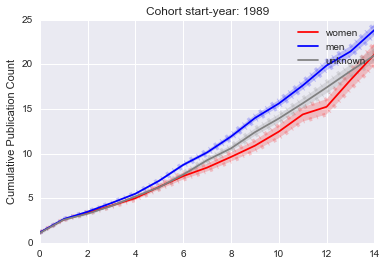

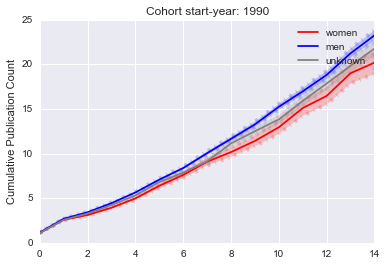

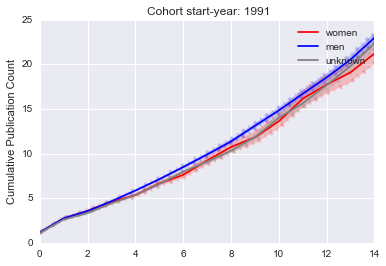

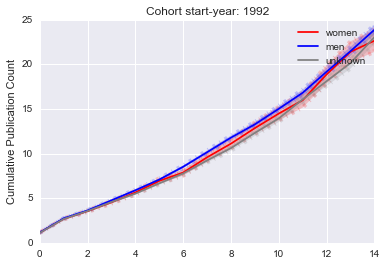

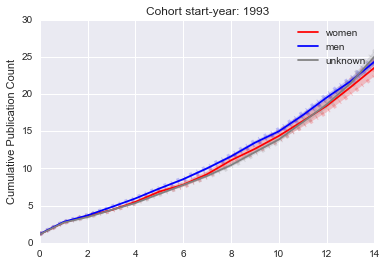

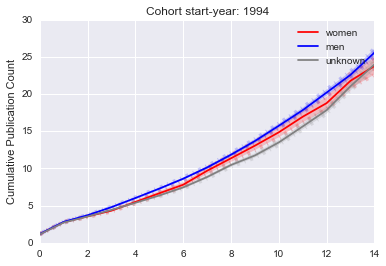

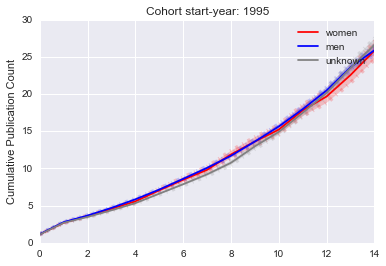

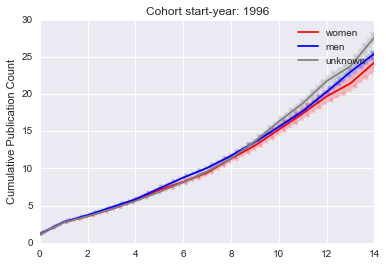

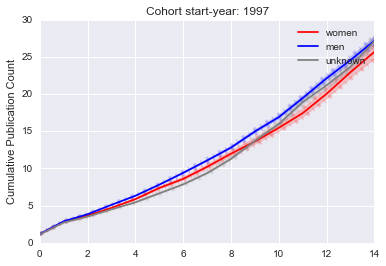

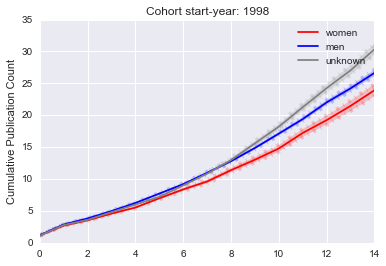

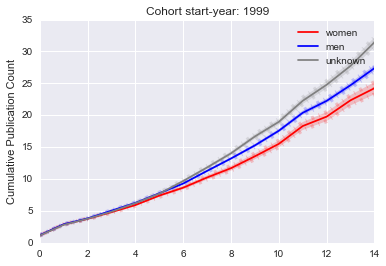

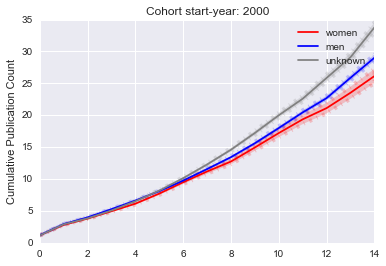

In [30]:
print(authorStartEndCareerData.head(n=1))
gini_per_cohort = pd.DataFrame(index=years)
cumnumpub_per_cohort = pd.DataFrame(index=years)


fig0 = plt.figure()
ax0 = fig0.add_subplot(1,1,1)


fig2 = plt.figure()
ax2 = fig2.add_subplot(1,1,1)
fig3 = plt.figure()
ax3 = fig3.add_subplot(1,1,1)


max_years = 15
# limit plot to the N years during which we follow a cohort
cohort_duration = np.arange(max_years)

# 30 years
fig5 = plt.figure(figsize=(40,20))

i=1

for year in years: #[1975,1980,1985, 1990]: #
    #we cannot follow the cohort for max years; for 2016 we do not have enough data
    if year > (2015 - max_years):
        break
    
    ax5 = fig5.add_subplot(6, 6, i)
    i = i+1
    
    fig4 = plt.figure()
    ax4 = fig4.add_subplot(1, 1, 1)

    #print("cohort: "+str(year))
    cohort = authorStartEndCareerData[authorStartEndCareerData["start_year"]==year]
    cohort_authors = cohort["author"].values
  
    gini_over_years = pd.Series(data=0, index=years)
    cumnumpub_over_years = pd.DataFrame(data=0, index=years, columns=["mean", "std", "mean_f", "std_f", "mean_m", "std_m", "mean_n", "std_n"])
 
    # extract num publications for the cohort in all future years
    for y in range(year, max(years)+1):
        #print("following years: "+str(y))
      
        # get all the authors data for each year and filter based on the authors that we are interested in
        temp = groupByAuthorYearData[groupByAuthorYearData["year"]==y]
        temp = temp[temp["author"].isin(cohort_authors)]
        
        # gini per year based on cumulative num of publications of all authors in this year
        gini_over_years.loc[y] = gini(temp['cum_num_pub'].astype("float").values)
        
        temp_male = temp[temp["gender"]=="m"]
        temp_female = temp[temp["gender"]=="f"]
        temp_none = temp[temp["gender"]=="none"]
        
        cumnumpub_over_years.loc[y] = [np.mean(temp['cum_num_pub'].astype("float").values), 
                                       np.std(temp['cum_num_pub'].astype("float").values),
                                       np.mean(temp_female['cum_num_pub'].astype("float").values), 
                                       stats.sem(temp_female['cum_num_pub'].astype("float").values),
                                       np.mean(temp_male['cum_num_pub'].astype("float").values), 
                                       stats.sem(temp_male['cum_num_pub'].astype("float").values),
                                       np.mean(temp_none['cum_num_pub'].astype("float").values), 
                                       stats.sem(temp_none['cum_num_pub'].astype("float").values)]
        
    
   
    gini_years_df = pd.DataFrame(gini_over_years.reset_index())
    gini_years_df.columns = ["year", "gini"]
    #gini_per_cohort[year] = gini_years_df
   
    gini_years = gini_years_df["year"].values
    gini_coefs= gini_years_df["gini"].values
    selected_gini_df = gini_years_df[(gini_years_df["year"] >= year) &  (gini_years_df["year"] < (year+max_years))]
    ax2.plot(cohort_duration, selected_gini_df["gini"])
   
    #["mean", "std", "mean_f", "std_f", "mean_m", "std_m", "mean_n", "std_n"])
    cumnumpub_years_df = pd.DataFrame(cumnumpub_over_years.reset_index())
    cumnumpub_years_df.columns = ["year", "mean", "std", "mean_f", "sem_f", "mean_m", "sem_m", "mean_n", "sem_n"]
    #cumnumpub_per_cohort[year] = cumnumpub_years_df
   
    selected_cumnumpub_df = cumnumpub_years_df[(cumnumpub_years_df["year"] >= year) &  (cumnumpub_years_df["year"] < (year+max_years))]
    ax3.errorbar(cohort_duration, selected_cumnumpub_df["mean"].values,  yerr=selected_cumnumpub_df["std"].values)
    
    
    ax4 = plot_gender_numcumpub(ax4, cohort_duration, selected_cumnumpub_df, year)
    ax4.set_title("Cohort start-year: "+str(year))  
    ax4.set_ylabel('Cumulative Publication Count')
    ax4.legend()
    fig4.savefig("fig/cumnumpub_gender_"+str(year)+".png")
    
    ax5 = plot_gender_numcumpub(ax5, cohort_duration, selected_cumnumpub_df, year)
    ax5.set_title("Cohort start-year: "+str(year))



ax2.set_ylabel('Gini')
ax2.set_title('Inequality of al cohorts over '+str(max_years)+' years')
if len(years)<10:
    ax2.legend(years)  
fig2.savefig("fig/gini.png")

ax3.set_ylabel('Cumulative Publication Count')
ax3.set_title('Mean/Std of al cohorts over '+str(max_years)+' years')
if len(years)<10:
    ax3.legend(years)  
    
fig3.savefig("fig/cumnumpub.png")

fig5.savefig("fig/cumnumpub_gender.png")
  
plt.show()

   


In [33]:
years

array([1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980,
       1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991,
       1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002,
       2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013,
       2014, 2015, 2016])

In [36]:
cohort_authors_list = []
cohort_credible_authors_list = []
for year in years: #[1975,1980,1985, 1990]: #
    #we cannot follow the cohort for max years; for 2016 we do not have enough data

    #print("cohort: "+str(year))
    cohort = authorStartEndCareerData[authorStartEndCareerData["start_year"]==year]
    cohort_authors = cohort["author"].values
    cohort_authors_list.append(len(set(cohort_authors)))
    
    cohort_credible = credibleAuthorStartEndCareerData[credibleAuthorStartEndCareerData["start_year"]==year]
    cohort_credible_authors = cohort_credible["author"].values
    #print(cohort_credible_authors)
    #print(len(set(cohort_credible_authors)))
    cohort_credible_authors_list.append(len(set(cohort_credible_authors)))
    #break
print(cohort_authors_list)
print(cohort_credible_authors_list)

[1835, 2092, 1982, 2299, 2646, 2465, 2819, 3023, 3005, 3165, 3813, 4069, 4908, 5259, 6376, 6273, 8267, 8838, 10720, 11554, 14037, 15028, 16943, 20800, 22956, 22949, 23742, 27081, 30111, 33623, 37590, 42074, 45634, 56919, 66725, 75357, 80191, 86222, 94403, 100290, 103104, 112148, 113598, 114504, 116971, 118000, 21777]
[851, 855, 778, 931, 924, 891, 1049, 1188, 1126, 1195, 1444, 1516, 1850, 1944, 2298, 2186, 3001, 3181, 3831, 4110, 4900, 5249, 5734, 6867, 7194, 6807, 6911, 7336, 7624, 7493, 6758, 2866, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


### Ranking of men and women in this distribution

Num-publication distribution. What is the mean/median rank of men and women. For which cohorts do we find a significant differnce after 10 or 15 years?



In [ ]:
end_time = timeit.default_timer()
print(end_time)
print('Time taken - ',end_time-start_time)

### Stability of Ranking

How stable is the ranking ober time. We expect that at the top the ranking is rather stable.
How much rank-increase do men and women achieve over the years?

